In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

from models import *
%load_ext autoreload
%autoreload 2

# PCA
## Load data

In [2]:
X = pd.read_csv('./leaf.csv', header=None).values[:,2:]
X.shape

(340, 14)

## 1.1

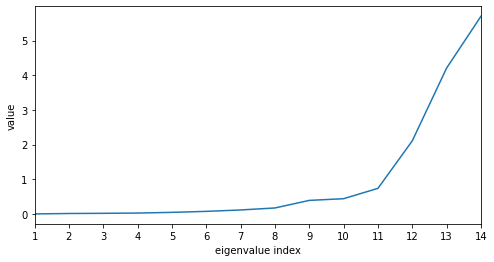

In [3]:
# scale data
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_scaled = (X-mean) / std

# calculate covariance matrix
cov = np.cov(X_scaled.T)

# calculate eigenvectors and eigenvalues
eig_vals, eig_vecs = np.linalg.eig(cov)

# plot eigenvalues in ascending order
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(eig_vals))+1,np.sort(eig_vals))
plt.xlim([1,len(eig_vals)])
plt.xlabel('eigenvalue index')
plt.ylabel('value')
plt.xticks(np.arange(len(eig_vals))+1)
plt.show()

## 1.2

In [4]:
# selecting how many eigenvalues to use (choosing k)
eig_vals_percentage = np.flip(np.sort(eig_vals))/np.sum(eig_vals)
ks = np.arange(len(eig_vals))+1
k_sums = np.zeros_like(eig_vals)
for k, val in enumerate(eig_vals_percentage):
    k_sums[k] = k_sums[k-1]+val
    if k_sums[k]>0.95 and k_sums[k-1]<0.95:
        print(f'k={k+1} is a good choise of k')
pd.DataFrame({'k':ks, 'coverage %':k_sums}, columns= ['k', 'coverage %']).style.hide_index()

k=6 is a good choise of k


k,coverage %
1,0.405919
2,0.705545
3,0.855692
4,0.908231
5,0.939495
6,0.967268
7,0.979499
8,0.987630
9,0.992872
10,0.996110


## 1.3

In [5]:
# printing the eigenvectors for k=2
pd.DataFrame({'w1':eig_vecs[0], 'w2':eig_vecs[1]}, columns= ['w1', 'w2'])

,w1,w2
0,-0.093812,-0.190165
1,-0.192439,-0.025256
2,0.538282,0.519236
3,0.129275,-0.168502
4,-0.172358,0.463153
5,-0.617888,0.470015
6,0.009354,0.177409
7,0.003232,0.371746
8,0.225518,0.179096
9,0.413895,0.128162


## 1.4

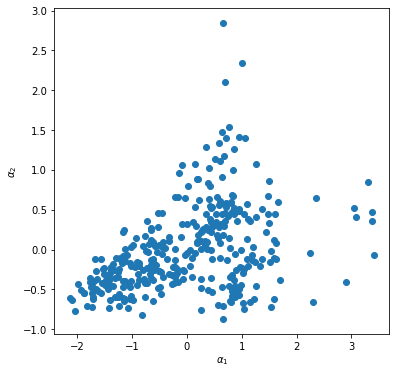

In [6]:
# calculate  and plat data on PCA space
alpha1 = X_scaled.dot(eig_vecs[0])
alpha2 = X_scaled.dot(eig_vecs[1])
plt.figure(figsize=(6,6))
plt.scatter(alpha1,alpha2)
plt.xlabel(r'$\alpha_1$')
plt.ylabel(r'$\alpha_2$')
plt.show()

## 1.5

In [7]:
# calculate mean squared reconstruction error
X_pca = np.zeros_like(X)
for i in range(X_pca.shape[0]):
    X_pca[i] = eig_vecs[:2].T.dot(eig_vecs[:2].dot(X_scaled[i]))
MSE = np.mean((X_scaled-X_pca)**2)
print(f'The Mean squared reconstruction error is {MSE}')

The Mean squared reconstruction error is 0.8945838270456161


# Task 1 - EM Algorithm
## Load Data

In [8]:
data = pd.read_csv('./data.csv', header=None).values
T = data[:,:-1]
y = data[:,-1]
print(T.shape, y.shape)
c_vals = np.array(list(set(y)))
n_d = len(y)
n_c = len(c_vals)
n_w = T.shape[1]

(400, 100) (400,)


In [9]:
# initialize pi #
# pi = np.array([np.sum(y==c)/len(y) for c in c_vals]) # real probabilities
pi = np.ones(n_c) / n_c # works well, but also might be because it's also the real distribution

# initialize mu #
# mu = np.array([[np.sum(T[:,j]*(y==c_vals[c]))/np.sum(T) for c in range(n_c)] for j in range(n_w)]) # real probabilities
mu = np.random.uniform(size=(n_w,n_c)) # works well, but obviously results depends on iterations and how lucky we are with the random values
# mu = np.ones((n_w,n_c)) # doesn't work, causes all dataset to concentrate into a single label
mu /= np.sum(mu) # normalization of mu

# initialize gamma #
gamma = np.zeros((n_d,n_c))

# iterate EM algorithm
iters = 50
for iter in range(iters):
    # E-step
    for i in range(n_d):
        for c in range(n_c):
            gamma[i,c] = np.nan_to_num((pi[c]*np.prod(mu[:,c]**T[i,:])) / (np.sum(pi*np.prod(mu**np.tile(T[i,:],(n_c,1)).T,axis=0))))
    # M-step
    for c in range(n_c):
        pi[c] =  np.sum(gamma[:,c]) / n_d
        for j in range(n_w):
            mu[j,c] = np.sum(gamma[:,c]*T[:,j]) / np.sum(np.tile(gamma[:,c],(100,1)).T*T)


In [10]:
# check accuracy
y_pred = np.argmax(gamma,axis=1)
y_pred_matched = np.zeros_like(y_pred)
for val in list(set(y_pred)):
    hist, bins = np.histogram(y[y_pred==val],bins=np.arange(c_vals.min(),c_vals.max()+2))
    print(f'predicted label {val} is most likely label {c_vals[np.argmax(hist)]} {hist}')
    y_pred_matched[y_pred==val] = c_vals[np.argmax(hist)]
acc = np.mean(y==y_pred_matched)
print(f'The accuracy of the EM Algorithm is {acc}')

predicted label 0 is most likely label 4 [ 0 38  0 99]
predicted label 1 is most likely label 2 [ 0 37 30  0]
predicted label 2 is most likely label 3 [ 0 12 70  1]
predicted label 3 is most likely label 1 [100  13   0   0]
The accuracy of the EM Algorithm is 0.765


# Task 2 - MCMC Algorithm

## Load data and declare distribution parameters

In [11]:
x = np.loadtxt('./data2.txt')
K = 2                   # Number of clusters
np.random.seed(7)

# Distribution parameters 
delta = np.ones(K)                          # Dirichlet distribution parameters: delta
a, b = 7, 5                                 # Gamma distribution parameters: a, b
m = np.linspace(np.min(x) + 1/18*x.std(),np.max(x) - 1/18*x.std(),num=K)  # Normal distribuion parameters: mean 
alpha = x.std()*np.random.rand(K) + 0.001    #  std

In [12]:
%reload_ext autoreload
n_iter = 1000

# 1. Set initials values rho, mu, phi
rho = np.random.dirichlet(np.ones(K))                  # Dirichlet distribution
phi = np.random.gamma(a/2,b/2,size=(K))                 # Gamma distribution
mu = m    # Normal distribution normalized

# print(rho, rho.shape)
# print(phi, phi.shape)
# print(mu, mu.shape)

for i in range(n_iter):
    # 2. Update z sampling z^(j+1)
    z = np.argmax(p_zi_xi(x,rho,mu,phi),axis=1)
    nk = np.sum(z.reshape(-1,1) == np.arange(K), axis=0)    # calculate nk for each k

    # 3. Update rho sampling from rho^(j+1)
    delta_conj = delta + nk                     # Delta conjugate
    rho = np.random.dirichlet(delta_conj)    # TO DO

    # 4. Update phi sampling from phi^(j+1)
    a_conj = a + nk
    one_hot = np.identity(K)[z].astype(bool)
    b_conj = b + np.array([np.power(x[one_hot[:,k]]-mu[k], 2).sum() for k in range(K)])
    phi = np.random.gamma(a_conj/2,b_conj/2,size=(K)) 

    # 5. Update mu sampling from mu^(j+1)
    alpha_conj = alpha + nk
    x_mean = np.array([x[one_hot[:,k]].mean() for k in range(K)])
    x_mean[np.isnan(x_mean)] = 0
    m_conj = (alpha*m + nk*x_mean)/(alpha + nk)
    mu = np.sqrt(1/(alpha_conj*phi)) * np.random.randn(K) + m_conj

print(rho, rho.shape)
print(phi, phi.shape)
print(mu, mu.shape)

[0.54930178 0.45069822] (2,)
[1244.37836714 1005.0565024 ] (2,)
[0.32271819 0.60089641] (2,)


In [13]:
print(rho, rho.shape)
print(phi, phi.shape)
print(mu, mu.shape)

[0.54930178 0.45069822] (2,)
[1244.37836714 1005.0565024 ] (2,)
[0.32271819 0.60089641] (2,)


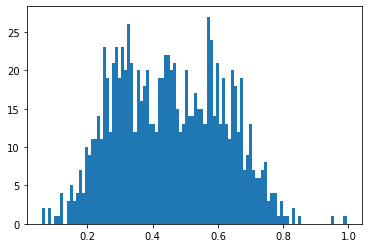

In [14]:
plt.hist(x,bins=100);

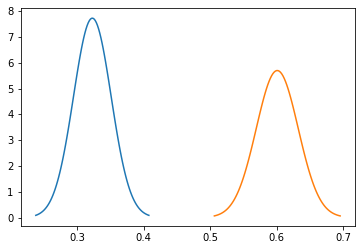

In [15]:
for k in range(K):
    mu_p = mu[k]
    variance = 1/phi[k]
    sigma = math.sqrt(variance)
    x_p = np.linspace(mu_p - 3*sigma, mu_p + 3*sigma, 100)
    plt.plot(x_p, rho[k]*stats.norm.pdf(x_p, mu_p, sigma))